In [2]:
%load_ext autoreload
%autoreload 2
import torch
import pandas as pd
import os
import torch.nn.functional as F
from data_loader.data_loaders import SkillflowDataset, SkillDataLoader
from data_loader.utils import _generate_data
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx, from_networkx
from torch_geometric.data import Data, HeteroData
from torch_geometric.loader import DataLoader as GeoDataLoader
import networkx as nx

In [24]:
def _get_matrices(count, time_range):
    '''get normalized company-position pairwise matrix data
    '''
    matrices = {}
    # build matrix
    for time in time_range:
        matrix = count[time]
        matrix[matrix.isna()] = 0.0
        matrix += 1.0  # avoid divided by 0
        matrices[time] = torch.from_numpy(matrix.values.astype('float32'))
    # stack data
    matrices = torch.stack(list(matrices.values())).float()
    # normalize data
    matrices = F.normalize(matrices, dim=0)
    # matrices = (matrices - matrices.min()) / (matrices.max() - matrices.min())
    return matrices

In [5]:
graph_dir = "./data/myGraph.gpickle"
data_dir = "./data/skill_inflow_outflow/"
device = "cuda:1"

In [2]:
datasetinflow =  pd.read_csv(
            os.path.join(data_dir, "skill_inflow_list.csv"),
            encoding='utf-8',
            header=0,
            on_bad_lines='warn',
            index_col=False
        ).T
datasetinflow.columns = datasetinflow.loc["time_attr"]
datasetinflow.drop("time_attr", axis=0, inplace=True)
datasetoutflow =  pd.read_csv(
            os.path.join(data_dir, "skill_outflow_list.csv"),
            encoding='utf-8',
            header=0,
            on_bad_lines='warn',
            index_col=False
        ).T
datasetoutflow.columns = datasetoutflow.loc["time_attr"]
datasetoutflow.drop(["time_attr"], axis=0, inplace=True)
time_range = datasetinflow.columns.value_counts().sort_index().index.tolist()

In [274]:
# graph = nx.read_gpickle(graph_dir)
# # graph[0][1]["weight"]
# [(u,v) for (u,v,d) in graph.edges(data=True) if int(d["weight"])==1]
# graph = from_networkx(graph, group_edge_attrs=['weight'])
# graph
# graph
# data = HeteroData()
# data['node', 'is_parent', 'node'].edge_index = graph.edge_index[:, ]
# data
# graph.edge_index[:,2]
# (graph.edge_attr.int() == 1).nonzero()[:,0]
graph.edge_index[:, (graph.edge_attr.int() == 1).nonzero()[:,0]]

torch.Size([2, 163563])

In [275]:
# dataset = SkillflowDataset(data_dir, graph_dir,1024,18)
loader = SkillDataLoader(data_dir, graph_dir,batch_size=1024, validation_split=0.16)

In [214]:
valid_loader = loader.split_validation()

In [277]:
graph = loader.graphdataloader.dataset
graph
# [it['Y_Label'][0] for it in loader.sampler]

HeteroData(
  (node, is_parent, node)={ edge_index=[2, 163563] },
  (node, is_child, node)={ edge_index=[2, 163563] },
  (node, temp, node)={ edge_index=[2, 0] },
  (node, relate, node)={ edge_index=[2, 1546152] }
)

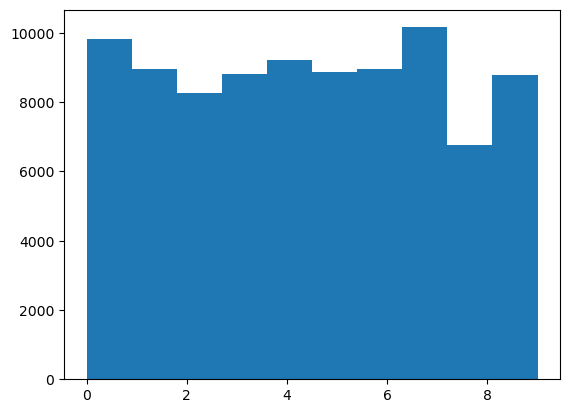

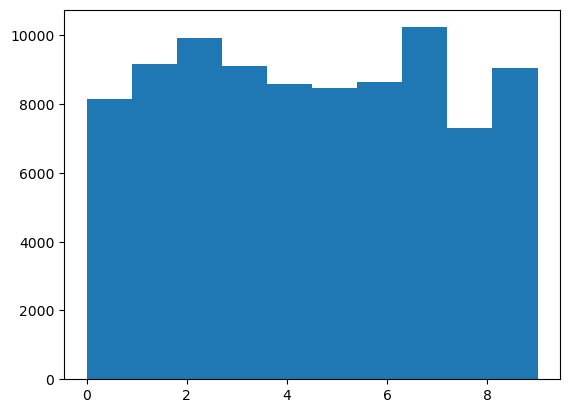

In [165]:
len_valid = len(valid_loader.sampler)
plt.hist(np.array([it['Y_Label'][0] for it in loader.dataset.data[:-1*len_valid]]))
plt.show()
plt.hist(np.array([it['Y_Label'][1] for it in loader.dataset.data[:-1*len_valid]]))
plt.show()

17
tensor([10235,  2316,  7354,  ...,  6325,  3930, 10192])


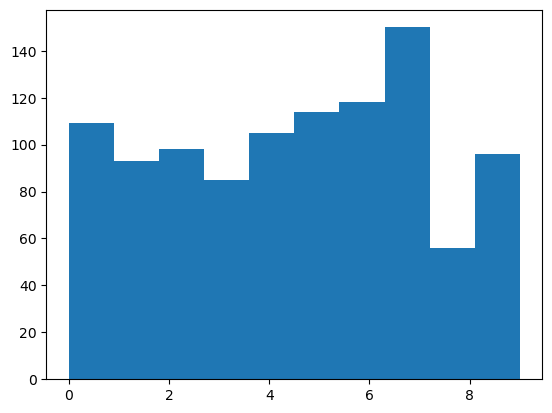

In [178]:
print(len(valid_loader))
for idx, batch in enumerate(valid_loader):
    (d_x_padded, s_x_padded), (d_y, s_y), l, s, t_s, t_e = batch
    print(s)
    plt.hist(d_y.cpu().detach().numpy())
    break


# len(loader.sampler)

In [26]:
#  problem involve torch geometric data in torch dataloader
for (idx, batch) in enumerate(loader):
    # print(batch)
    (d_x_padded, s_x_padded), (d_y, s_y), l, s, t_s, t_e = batch  # [3,7]
    print(d_x_padded.size())
    print(l.cpu())
    # print(d_y)
    break
# from matplotlib import pyplot as plt
# plt.hist(_get_matrices(datasetinflow, time_range)[10,:].cpu().numpy(), bins=100)

torch.Size([1024, 18])
tensor([ 8, 14,  8,  ...,  8, 14,  8])


In [44]:
data, demand_matrices, supply_matrices = _generate_data(datasetinflow, datasetoutflow, time_range, [*range(11721)], 5, 12)

In [55]:
from torch.utils.data import Dataset, DataLoader
DataLoader(data, batch_size=1024, shuffle=True, pin_memory=True)

In [108]:

graph = from_networkx(nx.read_gpickle(graph_dir))


NameError: name 'batch_size' is not defined

In [109]:
GeoDataLoader(graph, batch_size=100, shuffle=True)

In [115]:
GeoDataLoader(graph, batch_size=100, shuffle=True).dataset

Data(edge_index=[2, 1873278], weight=[1873278], num_nodes=11721)

In [1]:
%load_ext autoreload
%autoreload 2
import argparse
import collections
import torch
import torch_geometric
import numpy as np
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from parse_config import ConfigParser
# del Trainer
from trainer import Trainer
from utils import prepare_device
from model import model

In [2]:
args = argparse.ArgumentParser(description='PyTorch Template')
args.add_argument('-c', '--config', default='config.json', type=str,
                  help='config file path (default: None)')
args.add_argument('-r', '--resume', default=None, type=str,
                  help='path to latest checkpoint (default: None)')
args.add_argument('-d', '--device', default=None, type=str,
                  help='indices of GPUs to enable (default: all)')
# args = args.parse_args(args=['--config', 'config.json',  '--device','2'])
# custom cli options to modify configuration from default values given in json file.
CustomArgs = collections.namedtuple('CustomArgs', 'flags type target')
options = [
    CustomArgs(['--lr', '--learning_rate'], type=float, target='optimizer;args;lr'),
    CustomArgs(['--bs', '--batch_size'], type=int, target='data_loader;args;batch_size')
]
config = ConfigParser.from_args(args, options)
print(type(config))

<class 'parse_config.ConfigParser'>


In [22]:
print(config.config["hparam"]["class_num"])
# print(metrics)

10


In [3]:
SEED = 123
torch_geometric.seed.seed_everything(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# np.random.seed(SEED)

In [4]:
logger = config.get_logger('train')

# setup data_loader instances
print('Loading data...')
data_loader = config.init_obj('data_loader', module_data)
valid_data_loader = data_loader.split_validation()

Loading data...


In [5]:
# build model architecture, then print to console

print('Constructing model...')
model = config.init_obj('arch', module_arch, [data_loader.dataset.graph.to('cpu')]+[i for i in range(17)])
logger.info(model)

# prepare for (multi-device) GPU training
# device, device_ids = prepare_device(config['n_gpu'], config['device_id'])
device, device_ids = prepare_device(config['n_gpu'], config['device_id'])
device = "cpu"
model = model.to(device)
if len(device_ids) > 1:
    model = torch.nn.DataParallel(model, device_ids=device_ids)

# get function handles of loss and metrics
criterion = getattr(module_loss, config['loss'])
metrics = [getattr(module_metric, met) for met in config['metrics']]

# build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = config.init_obj('optimizer', torch.optim, trainable_params)
lr_scheduler = config.init_obj('lr_scheduler', torch.optim.lr_scheduler, optimizer)
# for state in optimizer.state.values():
# 	for k, v in state.items():
# 		if isinstance(v, torch.Tensor):
# 			state[k] = v.to(device)

Constructing model...
Skill_Evolve_Hetero(
  (criterion): NLLLoss()
  (dyskillhgnn): DySkillHGNN(
    (hgnn): HeteroHGNN(
      (heterognn): HeteroConv(num_relations=3)
    )
    (init_skill_emb): Embedding(11721, 128)
  )
  (demand_amplifier): Linear(in_features=1, out_features=128, bias=True)
  (supply_amplifier): Linear(in_features=1, out_features=128, bias=True)
  (skill_amplifier): Linear(in_features=256, out_features=128, bias=True)
  (position_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=16, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=16, out_features=128, bias=True)
        (norm1): 

In [14]:
torch.cuda.get_device_name(1)

'NVIDIA GeForce RTX 3090'

In [8]:
for name, W in model.named_parameters():
    print(name, W.device)
# next(model.parameters()).device
# model.dyskillhgnn.hg.to(d)
# torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

dyskillhgnn.hgnn.heterognn.convs.node__is_parent__node.att_src cuda:1
dyskillhgnn.hgnn.heterognn.convs.node__is_parent__node.att_dst cuda:1
dyskillhgnn.hgnn.heterognn.convs.node__is_parent__node.bias cuda:1
dyskillhgnn.hgnn.heterognn.convs.node__is_parent__node.lin_src.weight cuda:1
dyskillhgnn.hgnn.heterognn.convs.node__is_child__node.att_src cuda:1
dyskillhgnn.hgnn.heterognn.convs.node__is_child__node.att_dst cuda:1
dyskillhgnn.hgnn.heterognn.convs.node__is_child__node.bias cuda:1
dyskillhgnn.hgnn.heterognn.convs.node__is_child__node.lin_src.weight cuda:1
dyskillhgnn.hgnn.heterognn.convs.node__relate__node.att_src cuda:1
dyskillhgnn.hgnn.heterognn.convs.node__relate__node.att_dst cuda:1
dyskillhgnn.hgnn.heterognn.convs.node__relate__node.bias cuda:1
dyskillhgnn.hgnn.heterognn.convs.node__relate__node.lin_src.weight cuda:1
dyskillhgnn.init_skill_emb.weight cuda:1
demand_amplifier.weight cuda:1
demand_amplifier.bias cuda:1
supply_amplifier.weight cuda:1
supply_amplifier.bias cuda:1
ski

In [11]:
print("Start Training...")
# del trainer
trainer = Trainer(model, criterion, metrics, optimizer,
                  config=config,
                  device=device,
                  data_loader=data_loader,
                  valid_data_loader=valid_data_loader,
                  lr_scheduler=lr_scheduler)

trainer.train()

Start Training...


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.